In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# --------------------------
# VRPTW cost evaluator (your original logic kept intact)
# --------------------------
def preserving_strategy(X: np.ndarray, V: np.ndarray, **kwargs) -> float:
    visited_node = []
    cummulative_time = []
    cummulative_distance = []
    vehicle_loading = []
    
    # --- Unpack input data from keyword arguments ---
    dist = kwargs["distance"]  # Distance/time matrix between all nodes
    weight = kwargs["demand"]  # Demand (weight) for each customer node
    ready = kwargs["readyTime"]  # Ready time (earliest service time) for each node
    due = kwargs["dueDate"]  # Due time (latest service time) for each node
    service = kwargs["serviceTime"]  # Service time at each node
    vehicle = kwargs[
        "vehicle"
    ]  # Vehicle: [number of vehicles, capacity per vehicle]

    # Get per-vehicle capacities (by indexing with V)
    pre_w_cap = np.array([vehicle[1]] * vehicle[0])
    w_cap = pre_w_cap[V]

    # -- Initialization --
    sequence = X  # Route sequence (includes depot at start & end)
    n_cust = len(sequence) - 2  # Number of customers (not counting depot nodes)
    n_veh = vehicle[0] - 1  # Number of vehicles - 1 (for indexing)
    i, k = 0, 0  # i: current position in sequence, k: vehicle index
    total_distance = 0  # Store total traveled distance (with penalty if any)

    # -- Main loop over each vehicle route --
    while k <= n_veh and i <= n_cust:
        # Initialize per-route accumulators
        route_dist, route_time, weight_load, penaltyCost = 0, 0, 0, 0

        if k > 0:
            i += 1  # Move to the next start customer for the next vehicle
            
            
        # Start route: depot to first customer
        route_dist += dist[0][sequence[i]]  # Distance depot -> first customer
        route_time += (
            service[0] + dist[0][sequence[i]]
        )  # Service + travel time to first customer
        weight_load += weight[sequence[i]]  # Initial cargo: first customer demand

        # log information
        visited_node.append(0)
        visited_node.append(sequence[i])
        cummulative_distance.append(route_dist)
        cummulative_time.append(route_time)
        vehicle_loading.append(weight_load)


        if route_time < ready[sequence[i]]:
            route_time = ready[sequence[i]]  # Wait if vehicle arrives before ready time
            cummulative_time[-1] = route_time
        
        
        if route_time > due[sequence[i]] or weight_load > w_cap[k]:
            penaltyCost += 1e11  # Penalty: arrived after due time (infeasible)
            break

        # --- Continue visiting customers along this route ---
        while i <= n_cust:
            route_dist += dist[sequence[i]][sequence[i + 1]]  # Add next leg distance
            route_time += (
                service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
            )  # Add service + travel time
            weight_load += weight[sequence[i + 1]]  # Add new customer demand
            
            # log information0)
            visited_node.append(sequence[i+1])
            cummulative_distance.append(route_dist)
            cummulative_time.append(route_time)
            vehicle_loading.append(weight_load)

            if route_time < ready[sequence[i + 1]]:
                route_time = ready[sequence[i + 1]]  # Wait if arrive early at next node
                cummulative_time[-1] = route_time
                
            # If time window or capacity violated, backtrack and finish route
            if route_time > due[sequence[i + 1]] or weight_load > w_cap[k]:
                route_dist -= dist[sequence[i]][sequence[i + 1]]
                route_time -= service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
                weight_load -= weight[sequence[i + 1]]
                
                # log information
                cummulative_distance[-1] = route_dist
                cummulative_time[-1] = route_time
                vehicle_loading[-1] = weight_load
                
                
                break
            i += 1

        # --- Finish by returning to depot ---
        route_dist += dist[sequence[i]][0]  # Add distance to depot
        route_time += (
            service[sequence[i]] + dist[sequence[i]][0]
        )  # Add service at last node + travel to depot
        
        # log information
        visited_node[-1] = sequence[i]
        visited_node.append(0)
        cummulative_distance.append(route_dist)
        cummulative_time.append(route_time)
        
        if route_time > due[0]:
            penaltyCost += 1e11  # Penalty: returned to depot too late
        # Accumulate this route's total (distance + penalty if any)
        total_distance += route_dist + penaltyCost
    
        
        k += 1  # Next vehicle

    return total_distance, penaltyCost, visited_node, cummulative_distance, cummulative_time, vehicle_loading  # Return overall objective (distance with penalty if violated)
    


# --------------------------
# Decode a chromosome to (sequence, vehicle) and evaluate
# --------------------------
def objective_func(population: np.ndarray, **kwargs) -> float:
    vehicle = kwargs["vehicle"]
    # First block → customer order (rank-based decoding): smaller value → earlier visit
    seq = population[: -vehicle[0]].argsort() + 1
    
    # Last 'num_vehicles' genes → vehicle order/index (again rank-based)
    sort = population[-vehicle[0] :].argsort()
    obj_val = preserving_strategy(seq, sort)
    return obj_val

In [3]:
distance = (
    pd.read_excel(
        r"C:\rl-meta-test\src\Source\rl_meta_test_data_25_customer.xlsx",
        sheet_name="distance",
    )
    .fillna(9999999)
    .to_numpy()
)

df_vehicle = (
    pd.read_excel(
        r"C:\rl-meta-test\src\Source\rl_meta_test_data_25_customer.xlsx",
        sheet_name="vehicle",
    )
    .iloc[:, :2]
    .to_numpy(dtype=int)
)
vehicle = df_vehicle[0]

df_101 = pd.read_excel(
    r"C:\rl-meta-test\src\Source\rl_meta_test_data_25_customer.xlsx",
    sheet_name="customer",
).iloc[:, 3:]


demand = df_101.iloc[:, 0].to_numpy()
readyTime = df_101.iloc[:, 1].to_numpy()
dueDate = df_101.iloc[:, 2].to_numpy()
serviceTime = df_101.iloc[:, 3].to_numpy()

kwargs = {
        "distance": distance,
        "demand": demand,
        "readyTime": readyTime,
        "dueDate": dueDate,
        "serviceTime": serviceTime,
        "vehicle": vehicle,
    }

In [82]:
df_101_position = pd.read_excel(
    r"C:\rl-meta-test\src\Source\rl_meta_test_data_25_customer.xlsx",
    sheet_name="customer",
)
XC = df_101_position["XC"].to_numpy()
YC = df_101_position["YC"].to_numpy()

In [80]:
df_101

,demand,readyTime,dueTime,serviceTime,completeTime,duration
0,0,0,2000,0,0,0
1,10,912,967,90,1057,55
2,30,825,870,90,960,45
3,10,65,146,90,236,81
4,10,727,782,90,872,55
5,10,15,67,90,157,52
6,20,621,702,90,792,81
7,20,170,225,90,315,55
8,20,255,324,90,414,69
9,10,534,605,90,695,71


In [4]:
df_101

,demand,readyTime,dueTime,serviceTime,completeTime,duration
0,0,0,2000,0,0,0
1,10,912,967,90,1057,55
2,30,825,870,90,960,45
3,10,65,146,90,236,81
4,10,727,782,90,872,55
5,10,15,67,90,157,52
6,20,621,702,90,792,81
7,20,170,225,90,315,55
8,20,255,324,90,414,69
9,10,534,605,90,695,71


In [5]:
pos = np.array([0.60972822, 0.60203237, 0.00686598, 0.53469674, 0.        ,
       0.49675597, 0.33599047, 0.38668084, 0.47932859, 0.43868915,
       0.46238341, 0.97306948, 0.71317324, 0.96586001, 0.95973565,
       0.96018005, 0.7603234 , 0.79858067, 0.86380217, 0.61021892,
       0.70277587, 0.70242004, 0.69298186, 0.63903619, 0.68150968,
       0.23148577, 0.11083296, 0.68725388, 0.48854243, 0.6608216 ,
       0.19798231, 0.93844683, 0.04002987, 0.29185109, 0.54947132,
       0.52188057, 0.34255223, 0.70884523, 0.51688922, 0.62557905,
       0.60274914, 0.71878159, 0.54221278, 0.83607951, 0.16885725,
       0.3870068 , 0.64844865, 0.65461664, 0.81743506, 0.05290498])

In [6]:
pos.shape

(50,)

In [7]:
# First block → customer order (rank-based decoding): smaller value → earlier visit
seq = pos[: -vehicle[0]].argsort() + 1

# Last 'num_vehicles' genes → vehicle order/index (again rank-based)
sort = pos[-vehicle[0] :].argsort()

In [8]:
seq

array([ 5,  3,  7,  8, 10, 11,  9,  6,  4,  2,  1, 20, 24, 25, 23, 22, 21,
       13, 17, 18, 19, 15, 16, 14, 12], dtype=int64)

In [9]:
sort.shape

(25,)

In [10]:
total_distance, penaltyCost, visited_node, cummulative_distance, cummulative_time, vehicle_loading = preserving_strategy(seq, sort, **kwargs)

In [13]:
edit_seq =  np.array([0, 5, 3, 7, 8, 10, 11, 9, 6, 4, 2, 1, 0, 20, 24, 25, 23, 22, 21, 0, 13, 17, 18, 19, 15, 16, 14, 12, 0 ])

In [16]:
print(f'SOLUTION')
print(f'Total traveling distance (Algorithm) : {total_distance} Km.')
print(f'Penalty cost (Algorithm): {penaltyCost}')
print('Before')
print(f'Sequence (Algorithm): {visited_node}')
print(f'after (Bug)')
print(f'Sequence (Algorithm): {np.array([0, 5, 3, 7, 8, 10, 11, 9, 6, 4, 2, 1, 0, 20, 24, 25, 23, 22, 21, 0, 13, 17, 18, 19, 15, 16, 14, 12, 0 ])}')
print('-'*100)
print('DISTANCE CHECKING')
print(f'vehicle 1 distance (Algorithm) : {cummulative_distance[:13]}')
print(f'vehicle 1 distance (calcualted) : {cal_test1}')
print(f'vehicle 2 distance (Algorithm) : {cummulative_distance[13:21]}')
print(f'vehicle 2 distance (calcualted) : {cal_test2}')
print(f'vehicle 3 distance (Algorithm) : {cummulative_distance[21:]}')
print(f'vehicle 3 distance (calcualted) : {cal_test3}')
print('-'*100)
print('Time CHECKING')
print(f'vehicle 1 distance (Algorithm) : {cummulative_distance[:13]}')
print(f'vehicle 1 distance (calcualted) : {cal_test1}')
print(f'vehicle 2 distance (Algorithm) : {cummulative_distance[13:21]}')
print(f'vehicle 2 distance (calcualted) : {cal_test2}')
print(f'vehicle 3 distance (Algorithm) : {cummulative_distance[21:]}')
print(f'vehicle 3 distance (calcualted) : {cal_test3}')

SOLUTION
Total traveling distance (Algorithm) : 191.81361977865598 Km.
Penalty cost (Algorithm): 0
Before
Sequence (Algorithm): [0, 5, 3, 7, 8, 10, 11, 9, 6, 4, 2, 1, 1, 0, 0, 20, 24, 25, 23, 22, 21, 21, 0, 0, 13, 17, 18, 19, 15, 16, 14, 12, 0]
after (Bug)
Sequence (Algorithm): [ 0  5  3  7  8 10 11  9  6  4  2  1  0 20 24 25 23 22 21  0 13 17 18 19
 15 16 14 12  0]
----------------------------------------------------------------------------------------------------
DISTANCE CHECKING
vehicle 1 distance (Algorithm) : [15.1327459504215, 16.1327459504215, 18.1327459504215, 20.961173075167693, 24.566724350631674, 27.566724350631674, 30.729002010800045, 32.96506998829983, 35.20113796579962, 38.8066892412636, 40.8066892412636, 40.8066892412636, 59.488230933532996]
vehicle 1 distance (calcualted) : 59.488230933532996
vehicle 2 distance (Algorithm) : [10.0, 15.0, 17.0, 21.24264068711928, 24.24264068711928, 26.24264068711928, 26.242640687119277, 36.44067971430478]
vehicle 2 distance (calcualted)

In [15]:
cal_test1 = 0
cal_test2 = 0
cal_test3 = 0

cal_time1 = 0
cal_time2 = 0
cal_time3 = 0

test_seq1 = np.array([0, 5, 3, 7, 8, 10, 11, 9, 6, 4, 2, 1, 0])
test_seq2 = np.array([0, 20, 24, 25, 23, 22, 21, 0 ])
test_seq3 = np.array([0, 13, 17, 18, 19, 15, 16, 14, 12, 0])

for i in range(len(test_seq1)-1):
    cal_test1 += distance[test_seq1[i]][test_seq1[i+1]]
    cal_time1 += distance[test_seq1[i]][test_seq1[i+1]] + serviceTime[test_seq1[i]]

for i in range(len(test_seq2)-1):
    cal_test2 += distance[test_seq2[i]][test_seq2[i+1]]
    cal_time2 += distance[test_seq2[i]][test_seq2[i+1]] + serviceTime[test_seq2[i]]
    
for i in range(len(test_seq3)-1):
    cal_test3 += distance[test_seq3[i]][test_seq3[i+1]]
    cal_time3 += distance[test_seq3[i]][test_seq3[i+1]] + serviceTime[test_seq3[i]]

In [17]:
cummulative_time

[15.1327459504215,
 106.1327459504215,
 198.1327459504215,
 290.9611730751677,
 384.5667243506317,
 477.5667243506317,
 570.7290020108001,
 662.9650699882999,
 755.2011379657997,
 848.8066892412637,
 940.8066892412637,
 940.8066892412637,
 1049.488230933533,
 10.0,
 105.0,
 197.0,
 732,
 825.0,
 917.0,
 917.0,
 1017.1980390271855,
 30.8058436014987,
 124.80584360149871,
 217.8058436014987,
 312.80584360149874,
 407.80584360149874,
 502.80584360149874,
 594.8058436014987,
 687.8058436014987,
 815.8847091308182]

In [40]:
print(f'Ready time {readyTime[test_seq1[1:]]}')
print(f'Duedate time {dueDate[test_seq1[1:]]}')

Ready time [ 15  65 170 255 357 448 534 621 727 825 912   0]
Duedate time [  67  146  225  324  410  505  605  702  782  870  967 2000]


In [69]:
tw_test = [15.1327459504215,
 106.1327459504215,
 198.1327459504215,
 290.9611730751677,
 384.5667243506317,
 477.5667243506317,
 570.7290020108001,
 662.9650699882999,
 755.2011379657997,
 848.8066892412637,
 940.8066892412637,
 1049.488230933533]

tw_test2 = [10.0,
 105.0,
 197.0,
 732,
 825.0,
 917.0,
 1017.1980390271855]


tw_test3 =  [30.8058436014987,
 124.80584360149871,
 217.8058436014987,
 312.80584360149874,
 407.80584360149874,
 502.80584360149874,
 594.8058436014987,
 687.8058436014987,
 815.8847091308182]


In [71]:
solution = test_seq3
tw_solution = tw_test3
test_readytime = readyTime[solution] 
test_duedatetime = dueDate[solution]
 
for i in range(len(test_readytime)-1):
    
    if test_readytime[i+1] <= tw_solution[i] and tw_solution[i] <= test_duedatetime[i+1]:
        print('-'*100)
        print(f'Sequence idex {solution[i+1]} : Satisty constraint')
        print(f'Ready time node {solution[i+1]} | Visited time node {solution[i+1]}  | Duedate time node {solution[i+1]}')
        print(f'   {test_readytime[i+1]} <= {tw_solution[i]} <= {test_duedatetime[i+1]}')
        print('-'*100)
    else: 
        print(f'Sequence idex {i} : Violence constraint')

----------------------------------------------------------------------------------------------------
Sequence idex 13 : Satisty constraint
Ready time node 13 | Visited time node 13  | Duedate time node 13
   30 <= 30.8058436014987 <= 92
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Sequence idex 17 : Satisty constraint
Ready time node 17 | Visited time node 17  | Duedate time node 17
   99 <= 124.80584360149871 <= 148
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Sequence idex 18 : Satisty constraint
Ready time node 18 | Visited time node 18  | Duedate time node 18
   179 <= 217.8058436014987 <= 254
---------------------------------------------------------------------------------

In [ ]:
plt.scatter()

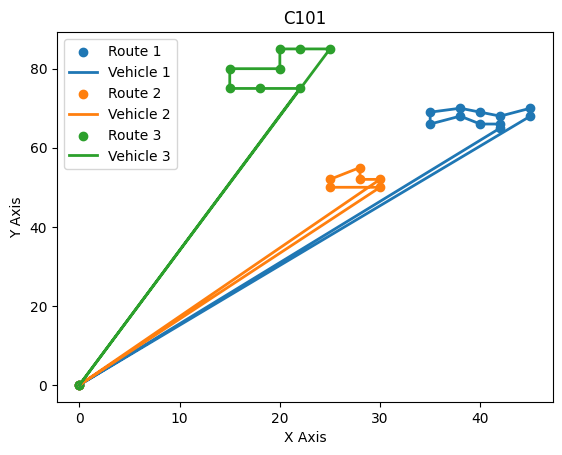

In [97]:
import matplotlib.pyplot as plt

x_vehicle1 = XC[test_seq1]
y_vehicle1 = YC[test_seq1]
x_vehicle2 = XC[test_seq2]
y_vehicle2 = YC[test_seq2]
x_vehicle3 = XC[test_seq3]
y_vehicle3 = YC[test_seq3]

plt.scatter(x_vehicle1, y_vehicle1, label='Route 1')   # วาดจุด
plt.plot(x_vehicle1, y_vehicle1, linewidth=2, label='Vehicle 1')  # วาดเส้นเชื่อมจุด
plt.scatter(x_vehicle2, y_vehicle2, label='Route 2')   # วาดจุด
plt.plot(x_vehicle2, y_vehicle2, linewidth=2, label='Vehicle 2')  # วาดเส้นเชื่อมจุด
plt.scatter(x_vehicle3, y_vehicle3, label='Route 3')   # วาดจุด
plt.plot(x_vehicle3, y_vehicle3, linewidth=2, label='Vehicle 3')  # วาดเส้นเชื่อมจุด



plt.title("C101")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.legend()
plt.show()
